#<font color= “blue”>SNS意見分析パイプラインの概要</font>
本プロジェクトでは、SNS上に投稿された意見データを対象に、自然言語処理技術を活用した意見分析パイプラインを構築しました。主な目的は、以下の通りです。

##1.感情分析
投稿テキストの前処理を行い、事前学習済みのTransformerモデル（CardiffNLPのTwitter用モデル）を用いて、テキストをポジティブ、ネガティブ、ニュートラルの各感情に分類します。


##2.テキストの埋め込みとクラスタリング
SentenceTransformerを利用して各投稿テキストの埋め込みベクトルを生成し、KMeansクラスタリングにより意見の類似性に基づいたグループ分けを行います。さらに、PCAを用いて高次元の埋め込みを2次元に次元削減し、Plotlyで可視化することで、各クラスタの特徴を視覚的に把握できるようにしています。


##3.代表意見の抽出と要約生成

各クラスタから代表的な意見を抽出し、GPT-4o-miniやvec2textを活用して、各グループの特徴を200文字程度の要約として生成します。また、要約文は日本語に翻訳し、より分かりやすい結果を提供します。


##4.使用技術の説明とドキュメンテーション
本コードはGoogle Colab Notebookの各セル（ブロック）に分割して実行可能な形で実装されており、各ブロックごとにその目的や機能について詳細なコメント・説明が記載されています。これにより、コード全体の流れが明確になり、解析の各ステップが容易に理解できる構造となっています。

<br>

#### 本パイプラインを用いることで、SNS上に散在する多様な意見を、感情分類、クラスタリング、可視化、そして要約という多角的なアプローチから解析することが可能となります。これにより、意見のトレンド把握や、特定の感情に基づいたグループの特徴抽出など、SNSデータの有効な活用が期待されます。



---



# 必要なライブラリのインストール

In [1]:
import kagglehub

path = kagglehub.dataset_download("asaniczka/public-opinion-on-democrats-updated-daily")
print("Path to dataset files:", path)

!pip install -U g4f[all]

import nest_asyncio
nest_asyncio.apply()

!pip install mplcursors
!pip install vec2text


100%|██████████| 0.98G/0.98G [00:13<00:00, 76.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/asaniczka/public-opinion-on-democrats-updated-daily/versions/432
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



---



#<font color= “blue”>データセット</font>

今回使用するデータセットには、民主党に関連する投稿に対する Reddit（アメリカ発祥の掲示板投稿型ソーシャルサイト） のコメントが含まれています。コメント ID、スコア、テキスト、サブレディット、投稿 ID、作成者名、論争性、ユーザー情報、投稿スコア、投稿テキスト、投稿タイトルなどのメタデータが含まれています。データセットは毎日更新されます。


* comment_id: 各コメントに割り当てられたユニークな識別子である。この列は、特定のコメントを識別するために使用される。
*author: コメントを投稿したユーザーのユーザー名である。これは、ユーザーの発言を追跡し、影響力のあるユーザーを特定するのに役立つ。
*subreddit: コメントが投稿されたSubredditの名前である。この列は、議論が行われた具体的なコミュニティを特定するために使用される。
*body: 実際のコメント内容を含むテキスト列である。この列は、感情分析やトピックモデリングなどの自然言語処理において主要なデータとなる。
*score: 各コメントのアップボートとダウンボートの差を示すスコアである。このスコアは、コメントがコミュニティでどれだけ支持されているかを示す指標となる。
*created_utc: コメントが投稿された時間をUTC形式で示すタイムスタンプである。この列は、時間経過による世論の変化を分析する際に使用される。
*controversiality: コメントがどれほど論争を引き起こしているかを示すスコアである。この値が高いほど、コメントが多くの議論を生んでいることを意味する。


データはKaggleのデータセットより入手します。



---



In [2]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(path, "reddit_opinion_democrats.csv"))

# データの先頭5行を表示
print(df.head())


<ipython-input-2-355108714f18>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "reddit_opinion_democrats.csv"))


  comment_id  score                                          self_text  \
0    mif8f9n      1  Buddy I got two dogs and I live on acres and a...   
1    mif8e4x      1                 Real trumpism has never been tried   
2    mif8db2      1  If you mention the crusade it's important to s...   
3    mif8cx9      1  Normies thinking us quiet weebs are just loser...   
4    mif8cno      1  Man, have you ever lost puzzle pieces? I have ...   

      subreddit         created_time  post_id     author_name  \
0    conspiracy  2025-03-18 12:04:05  1jdfhhc        celiajay   
1    neoliberal  2025-03-18 12:03:52  1jdz51i  Luton_town_fan   
2  changemyview  2025-03-18 12:03:41  1jdjq2w       MrNumber0   
3    neoliberal  2025-03-18 12:03:37  1jdz51i      gregorijat   
4      politics  2025-03-18 12:03:33  1je0wpo  ClusterFoxtrot   

   controversiality  ups  downs  ... user_link_karma user_comment_karma  \
0                 0    1      0  ...             1.0             1829.0   
1             



---



#<font color= “blue”>gpt4free</font>

GPT4FREEは、研究者、開発者、AI愛好家が高度なAIモデルの機能と制限を調査する際の障壁を無くし、誰でも自由に無料でGPT4などの高性能なモデルにアクセスできるようにするために作成されました。<br>
GPT4FREEは「GNU General Public License v3.0」でライセンスされています。<br>
今回はこのモデルを意見の要約や翻訳に使用します。

[モデルリンク](https://github.com/xtekky/gpt4free/tree/main)



---



In [4]:
import g4f
from g4f.client import Client

client = Client()
response = client.chat.completions.create(
    model="gpt-4o-mini",
    provider=g4f.Provider.DDG,
    messages=[{"role": "user", "content": "Hello"}],
    web_search=False
)
print(response.choices[0].message.content)


Hello! How can I assist you today?




---



#<font color= “blue”>感情分析</font>

2018 年 1 月から 2021 年 12 月までの約 1 億 2,400 万件のツイートでトレーニングされ、TweetEval ベンチマークを使用して感情分析用に微調整された RoBERTa ベースのモデルを使用します。

[モデルリンク](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

texts =["The sun shines brightly on a day filled with hope and endless possibilities.",
       "Dark clouds loom overhead, casting a shadow of despair and uncertainty over everything."]

for text in texts:
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    print(text)
    for i in range(scores.shape[0]):
        l = config.id2label[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The sun shines brightly on a day filled with hope and endless possibilities.
1) positive 0.9863
2) neutral 0.0119
3) negative 0.0018
Dark clouds loom overhead, casting a shadow of despair and uncertainty over everything.
1) negative 0.8689
2) neutral 0.1241
3) positive 0.007


#<font color= “blue”>vec2text</font>



---



##T5
T5(Text-to-Text Transfer Transformerの略語)
は分類、翻訳、要約といった様々な自然言語処理タスクを “Text-to-Text” で解くモデルです。<br>
“Text-to-Text” とは入力を"タスク：問題"、出力を"回答"の形式として、全てのタスクを同じモデルで解いてしまおうということです。以下がそのイメージになります。

t5.avif

画像引用元 : https://arxiv.org/abs/1910.10683



---



##gtr-t5-base

このモデルは、T5 ベース モデルのエンコーダーのみを使用し、重みは FP16 に保存されます。文章を768次元の密なベクトル空間にマッピングします。



---



##vec2text

このライブラリには、テキスト埋め込み反転を行うためのコードが含まれています。埋め込みからテキスト シーケンスを再構築するさまざまなアーキテクチャをトレーニングしたり、事前トレーニング済みのモデルを実行したりできます。

gtr ベースの埋め込みを反転できます。意見の要約に使用します。

In [ ]:
import vec2text
import torch
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer, PreTrainedModel


def get_gtr_embeddings(text_list,
                       encoder: PreTrainedModel,
                       tokenizer: PreTrainedTokenizer) -> torch.Tensor:

    inputs = tokenizer(text_list,
                       return_tensors="pt",
                       max_length=128,
                       truncation=True,
                       padding="max_length",).to("cuda")

    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings


encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

embeddings = get_gtr_embeddings([
       "Jack Morris is a PhD student at Cornell Tech in New York City",
       "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity"
], encoder, tokenizer)

vec2text.invert_embeddings(
    embeddings=embeddings.cuda(),
    corrector=corrector,
    num_steps=20,
)
['Jack Morris Morris is a PhD student at  Cornell Tech in New York City ',
'It was the best of times, it was the worst of times, it was the age of wisdom, it was the epoch of foolishness']




---



#<font color= “blue”> 主成分分析 (PCA) の概要</font>


## 1. 目的

　　元のデータ $ X \in \mathbb{R}^{n \times d} $（ここで、nはサンプル数、dは特徴数）から、情報をできるだけ失わずに次元を $k\quad(k < d) $ に<br>
　　削減することが目的です。つまり、主成分    $\quad w_1, w_2, \dots, w_k \in \mathbb{R}^d $
を求め、各サンプル $ x_i $ を

$$ z_i = W^T x_i \quad \text{（ただし } W = [w_1, w_2, \dots, w_k] \text{）} $$

　　に射影するという考え方です。

## 2. 前処理：データの中心化
　　各サンプル $ x_i $ に対して、

$$ x_i \leftarrow x_i - \bar{x} \quad (\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i) $$

　　とします。

## 3. 共分散行列の計算

　　中心化したデータ $ X $ に対して、共分散行列 $ C $ を計算します。

$$ C = \frac{1}{n-1} X^T X \in \mathbb{R}^{d \times d} $$

　　この行列は、各特徴間の共分散を表します。

## 4. 固有値分解（Eigen Decomposition）

　　共分散行列 $ C $ の固有値  $ \lambda_1, \lambda_2, \dots, \lambda_d $と対応する固有ベクトル  $ w_1, w_2, \dots, w_d $ を求めます。すなわち、

$$ C w_i = \lambda_i w_i \quad (i = 1, \dots, d) $$

　　ここで、固有値はデータの分散の大きさを表し、通常は

$$ \lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_d $$

　　の順に並びます。

## 5. 主成分の選択と射影

　　上位 $ k $ 個の固有値に対応する固有ベクトル（主成分）を選び、これを

$$ W = [w_1, w_2, \dots, w_k] \in \mathbb{R}^{d \times k} $$

　　とすると、各サンプル \( x_i \) は以下のように射影されます：

$$ z_i = W^T x_i \in \mathbb{R}^k $$

　　この射影されたベクトル $ z_i $ が低次元表現となります。



**利点：**  
- シンプルな数理モデルで計算量が少なく、直感的な解釈が可能  
- PCA は、データの分散が最大となる方向に沿ってデータを再構成するため、データの特徴や構造を理解する上で非常に有用です。




---



#<font color= “blue”>K-Means クラスタリングの概要</font>


K-Means クラスタリングは、与えられたデータをあらかじめ指定した $K$ 個のクラスタに分割する教師なし学習アルゴリズムです。各クラスタは、そのクラスタの重心（センター）によって代表されます。

## 1. 目的
　　K-Means の目的は、以下の目的関数（誤差関数）を最小化することです。

$$
J = \sum_{i=1}^{n} \sum_{k=1}^{K} r_{ik} \| x_i - \mu_k \|^2
$$

　ここで、
- $ n $ はデータポイントの総数、
- $ K $ はクラスタ数、
- $ x_i \in \mathbb{R}^d $ は $i$ 番目のデータポイント、
- $ \mu_k \in \mathbb{R}^d $ はクラスタ $ k $ の重心、
- $ r_{ik} $ は、データポイント $ x_i $ がクラスタ $ k $ に属する場合は 1、そうでなければ 0 です。

　この目的関数は、各データポイントとその所属するクラスタの重心との距離の二乗和を最小化することで、<br>
　データをできるだけ密にクラスタにまとめることを意味します。

## 2. アルゴリズムのステップ

### (1) 初期化  
　　ランダムに $K$個のクラスタの重心 $ \mu_1, \mu_2, \dots, \mu_K $ を初期化します。

### (2) 割り当てステップ (Assignment Step)  
　　各データポイント $ x_i $ に対して、最も近い重心 $ \mu_k $ を見つけ、以下のようにクラスタに割り当てます。

$$
r_{ik} = \begin{cases}
1, & \text{if } k = \underset{j}{\operatorname{argmin}}\, \| x_i - \mu_j \|^2 \\
0, & \text{otherwise}
\end{cases}
$$

### (3) 更新ステップ (Update Step)  
　　各クラスタ $ k $ に属する全データポイントの平均を計算し、重心 $ \mu_k
$ を更新します。

$$
\mu_k = \frac{\sum_{i=1}^{n} r_{ik} x_i}{\sum_{i=1}^{n} r_{ik}}
$$

### (4) 収束判定  
　　重心の位置がほとんど変化しなくなるか、または指定された反復回数に達するまで、(2) と (3) のステップを繰り返します。

## 3. 収束性と注意点
- **局所最適解:** K-Means は初期化に依存するため、局所最適解に収束する可能性があります。複数回実行して最適な結果を選択することが推奨されます。
- **クラスタ数の選択:** $K$ の値は事前に決める必要があり、エルボー法などを用いて適切な $K$ を選択します。

## 4. まとめ
　　K-Means は、各データポイントとクラスタの重心との距離の二乗和を最小化することでデータをクラスタに分割する、<br>
　　シンプルかつ高速なアルゴリズムです。  


　　そのシンプルさから直感的な解釈が可能であり、データの特徴や構造を理解する上で非常に有用ですが、<br>
　　初期化方法やクラスタ数の設定に注意が必要です。




---



#<font color= “blue”>分析用コード</font>

##Sentiment Analysis Setup
 テキストの前処理と、事前学習済みのTransformerモデルを使用して
 感情分析を行うための関数を定義します。

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

def preprocess(text: str) -> str:
    """
    テキスト内のユーザー名やURLをプレースホルダーに置換

    Args:
        text (str): 入力テキスト
    Returns:
        str: 前処理済みのテキスト
    """
    new_text = []
    for t in text.split(" "):
        if t.startswith('@') and len(t) > 1:
            t = '@user'
        elif t.startswith('http'):
            t = 'http'
        new_text.append(t)
    return " ".join(new_text)

# 感情分析モデルの設定
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def sentiment_analysis(text_list: list) -> tuple:
    """
    入力テキストリストに対して感情分析を実行し、ポジティブ・ネガティブ・ニュートラルの各リストを返す

    Args:
        text_list (list): テキストのリスト
    Returns:
        tuple: (positive_texts, negative_texts, neutral_texts)
    """
    positive_texts, negative_texts, neutral_texts = [], [], []

    for text in text_list:
        text = preprocess(text)
        encoded_input = tokenizer(text, truncation=True, max_length=512, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        num = np.argmax(scores)
        if num == 2:
            positive_texts.append(text)
        elif num == 0:
            negative_texts.append(text)
        else:
            neutral_texts.append(text)

    print(f"Positive Texts: {len(positive_texts)}")
    print(f"Negative Texts: {len(negative_texts)}")
    print(f"Neutral Texts: {len(neutral_texts)}")

    return positive_texts, negative_texts, neutral_texts


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Embedding, Clustering & Visualization Functions
 以下の機能を提供するクラス・関数を定義しています。
 1. テキストの埋め込み生成 (TextEmbedding)
 2. クラスタリング (Clustering)
 3. クラスタリング結果の可視化 (visualize_clusters_plotly)<br>

※ insert_br() はテキストの長さに応じて改行を挿入するヘルパー関数です。

In [7]:
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import transformers

# vec2text, g4f関連のライブラリも後で使用するためインポート
import vec2text
import g4f
from g4f.client import Client

client = Client()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TextEmbedding:
    """
    テキストを埋め込みベクトルに変換する
    """
    def __init__(self, model_name: str = "sentence-transformers/gtr-t5-base"):
        self.model = SentenceTransformer(model_name)

    def embed_texts(self, texts: list):
        """
        複数のテキストを埋め込みベクトルに変換

        Args:
            texts (list): テキストのリスト
        Returns:
            torch.Tensor: 埋め込みベクトル
        """
        return self.model.encode(texts, convert_to_tensor=True).to(device)

class Clustering:
    """
    KMeansを用いたクラスタリングを行う
    """
    def __init__(self, n_clusters: int = 3):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def cluster(self, embeddings: torch.Tensor):
        """
        埋め込みベクトルに対してクラスタリングを実施

        Args:
            embeddings (torch.Tensor): 埋め込みベクトル
        Returns:
            np.ndarray: 各テキストのクラスタラベル
        """
        self.labels = self.kmeans.fit_predict(embeddings.cpu().numpy())
        self.centroids = torch.tensor(self.kmeans.cluster_centers_, device=device)
        return self.labels

def insert_br(text: str, wrap_length: int = 30) -> str:
    """
    指定した文字数を超えた最初のスペースで改行（<br>）を挿入

    Args:
        text (str): 元のテキスト
        wrap_length (int): 改行を試みる文字数
    Returns:
        str: 改行を挿入したテキスト
    """
    index = wrap_length
    while index < len(text):
        space_index = text.find(" ", index)
        if space_index == -1:
            break
        text = text[:space_index] + "<br>" + text[space_index+1:]
        index = space_index + len("<br>") + wrap_length
    return text

def visualize_clusters_plotly(
        embeddings, labels, texts, centroids, selected_indices=None,
        width: int = 800, height: int = 600, marker_size: int = 10,
        wrap_length: int = 30, paper_bgcolor: str = "#fafafa",
        plot_bgcolor: str = "lightgray", title: str = "Opinion Clustering Visualization",
        title_size: int = 20):
    """
    PCAを用いて次元削減した後、Plotlyでクラスタリング結果を可視化

    Args:
        embeddings (torch.Tensor): 元の埋め込みベクトル
        labels (np.ndarray): クラスタラベル
        texts (list): オリジナルテキストのリスト
        centroids (torch.Tensor): 各クラスタの中心
        selected_indices (list, optional): 強調表示するテキストのインデックス
        その他、プロットの外観に関するパラメータ
    Returns:
        tuple: (reduced_embeddings, reduced_centroids)
    """
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())
    reduced_centroids = pca.transform(centroids.cpu().numpy())

    df = pd.DataFrame({
        "PCA1": reduced_embeddings[:, 0],
        "PCA2": reduced_embeddings[:, 1],
        "Cluster": labels,
        "Opinion": [insert_br(text, wrap_length) for text in texts],
        "Selected": "Regular"
    })

    unique_clusters = df["Cluster"].unique()
    base_colors = px.colors.qualitative.Set1[:len(unique_clusters)]
    color_map = {cluster: color for cluster, color in zip(unique_clusters, base_colors)}
    df["Color"] = df["Cluster"].map(color_map)

    available_symbols = [
        "circle", "square", "diamond", "cross", "triangle-up", "triangle-down",
        "pentagon", "hexagon", "star", "hexagram", "octagon", "bowtie",
        "hourglass", "star-diamond", "star-square", "star-triangle-up",
        "star-triangle-down", "triangle-left", "triangle-right", "circle-cross"
    ]
    symbol_map = {cluster: symbol for cluster, symbol in zip(unique_clusters, available_symbols)}
    df["Symbol"] = df["Cluster"].map(symbol_map)

    df_centroids = pd.DataFrame({
        "PCA1": reduced_centroids[:, 0],
        "PCA2": reduced_centroids[:, 1],
        "Cluster": range(len(reduced_centroids)),
        "Opinion": ["Cluster Center"] * len(reduced_centroids)
    })

    fig = go.Figure()

    # 各クラスタのデータポイントをプロット
    for cluster in unique_clusters:
        cluster_df = df[df["Cluster"] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df["PCA1"],
            y=cluster_df["PCA2"],
            mode="markers",
            marker=dict(size=marker_size, color=cluster_df["Color"].values[0],
                        opacity=0.7, symbol=cluster_df["Symbol"].values[0]),
            name=f"Cluster {cluster}",
            text=cluster_df["Opinion"],
            hoverinfo="text"
        ))
    # 選択されたデータポイントの強調表示
    if selected_indices is not None:
        for selected in selected_indices:
            selected_df = df.loc[selected]
            fig.add_trace(go.Scatter(
               x=selected_df["PCA1"],
               y=selected_df["PCA2"],
               mode="markers",
               marker=dict(size=marker_size + 5, color="#666666", opacity=0.6,
                           symbol=selected_df["Symbol"].values[0]),
               name="Selected Opinions",
               text=selected_df["Opinion"],
               hoverinfo="text"
           ))
    # クラスタ中心のプロット
    fig.add_trace(go.Scatter(
        x=df_centroids["PCA1"],
        y=df_centroids["PCA2"],
        mode="markers",
        marker=dict(size=marker_size + 6, color="black", symbol="x"),
        name="Cluster Centers"
    ))

    fig.update_layout(
        width=width,
        height=height,
        title=title,
        title_x=0.45,
        title_y=0.94,
        title_font=dict(size=title_size),
        paper_bgcolor=paper_bgcolor,
        plot_bgcolor=plot_bgcolor,
        hovermode="closest"
    )

    fig.show()
    return reduced_embeddings, reduced_centroids


##Clustering & Summarization Function
以下の処理を実施する関数 `test_func` を定義しています。
 1. テキストの埋め込み生成とクラスタリング
 2. 各クラスタから代表的なテキストを選出（埋め込みベースとPCAベースの2通り）
 3. GPTを用いて代表意見の要約・翻訳生成
 4. vec2text を用いたベクトルからの意見生成

In [8]:
def test_func(text_list: list, title: str, num_cluster: int, num_selectet_sentence: int,
              generate_from_sentence: bool, generate_from_vector: bool):
    """
    指定されたテキストリストに対してクラスタリングを実行し、代表的な意見を生成

    Args:
        text_list (list): テキストのリスト
        title (str): 結果出力用のタイトル
        num_cluster (int): クラスタ数
        num_selectet_sentence (int): 各クラスタから選出するテキスト数
        generate_from_sentence (bool): GPTによる要約生成を実施するかどうか
        generate_from_vector (bool): ベクトルからの意見生成を実施するかどうか

    Returns:
        tuple: (summary_sentence, selected_texts_embed, selected_texts_pca)
    """
    summary_sentence = {}

    # クラスタリングの実行
    embedding_model = TextEmbedding()
    embeddings = embedding_model.embed_texts(text_list)
    cluster_model = Clustering(n_clusters=num_cluster)
    labels = cluster_model.cluster(embeddings)

    # 埋め込みベクトルベースの代表テキスト選出
    selected_vectors_embed = {}
    average_vectors_embed = {}
    selected_texts_embed = {}
    selected_indices_embed = []

    for cluster_id in range(cluster_model.n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_embeddings = embeddings[cluster_indices]
        distances = torch.norm(cluster_embeddings - cluster_model.centroids[cluster_id], dim=1)
        closest_indices = cluster_indices[torch.argsort(distances).cpu().numpy()[:num_selectet_sentence]]

        selected_vectors_embed[cluster_id] = embeddings[closest_indices]
        selected_indices_embed.append(closest_indices.tolist())
        average_vectors_embed[cluster_id] = torch.mean(selected_vectors_embed[cluster_id], dim=0, keepdim=True)
        selected_texts_embed[cluster_id] = [text_list[i] for i in closest_indices]

    # 埋め込みベースの選出結果を可視化（PCAで次元削減）
    reduced_embeddings, reduced_centroids = visualize_clusters_plotly(
        embeddings, labels, text_list, cluster_model.centroids,
        selected_indices=selected_indices_embed,
        width=1200, height=900, marker_size=10,
        paper_bgcolor="#fafafa", plot_bgcolor="#EEEEEE",
        wrap_length=30, title=title + " Embedding-Based_Selection", title_size=20)

    # PCAベースの代表テキスト選出
    selected_vectors_pca = {}
    average_vectors_pca = {}
    selected_texts_pca = {}
    selected_indices_pca = []

    for cluster_id in range(cluster_model.n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_points = reduced_embeddings[cluster_indices]
        distances = np.linalg.norm(cluster_points - reduced_centroids[cluster_id], axis=1)
        closest_indices = cluster_indices[np.argsort(distances)[:num_selectet_sentence]]

        selected_vectors_pca[cluster_id] = embeddings[closest_indices]
        selected_indices_pca.append(closest_indices.tolist())
        average_vectors_pca[cluster_id] = torch.mean(selected_vectors_pca[cluster_id], dim=0, keepdim=True)
        selected_texts_pca[cluster_id] = [text_list[i] for i in closest_indices]

    # PCAベースの選出結果を可視化
    visualize_clusters_plotly(
        embeddings, labels, text_list, cluster_model.centroids,
        selected_indices=selected_indices_pca,
        width=1200, height=900, marker_size=10,
        paper_bgcolor="#fafafa", plot_bgcolor="#EEEEEE",
        wrap_length=30, title=title + " PCA-Based_Selection", title_size=20)

    print("\nRepresentative Opinion Generation\n")

    # vec2textによる代表意見生成の準備
    inversion_model = vec2text.models.InversionModel.from_pretrained("ielabgroup/vec2text_gtr-base-st_inversion")
    model = vec2text.models.CorrectorEncoderModel.from_pretrained("ielabgroup/vec2text_gtr-base-st_corrector")
    inversion_trainer = vec2text.trainers.InversionTrainer(
        model=inversion_model,
        train_dataset=None,
        eval_dataset=None,
        data_collator=transformers.DataCollatorForSeq2Seq(inversion_model.tokenizer, label_pad_token_id=-100),
    )
    corrector = vec2text.trainers.Corrector(
        model=model,
        inversion_trainer=inversion_trainer,
        args=None,
        data_collator=vec2text.collator.DataCollatorForCorrection(tokenizer=inversion_trainer.model.tokenizer),
    )

    # GPTによる要約生成（テキストベース）
    if generate_from_sentence:
        for key, selected_texts in {
            '\n\nEmbedding-based_selection generation_from_gpt': selected_texts_embed,
            '\n\nPCA-based_selection generation_from_gpt': selected_texts_pca
        }.items():
            print(key)
            summaries = []
            for cluster_id, opinions in selected_texts.items():
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    provider=g4f.Provider.DDG,
                    messages=[{"role": "user", "content": f"Please summarize clustered opinions in 200 characters: {opinions}"}],
                    web_search=False,
                )
                summary = response.choices[0].message.content
                summaries.append(summary)

                # 日本語翻訳の生成
                Japanese = client.chat.completions.create(
                    model="gpt-4o-mini",
                    provider=g4f.Provider.DDG,
                    messages=[{"role": "user", "content": f"Please translate the following sentence into Japanese. Return only the Japanese translated text: {summary}"}],
                    web_search=False,
                )
                Japanese_summary = Japanese.choices[0].message.content
                print(f"\nCluster {cluster_id+1} : {summary}")
                print(f"            {Japanese_summary}")
            summary_sentence[key] = summaries

    # vec2textによるベクトルからの意見生成
    if generate_from_vector:
        print('\n\nEmbedding-based_selection generation_from_vectors')
        summaries = []
        for cluster_id, avg_vector in average_vectors_embed.items():
            response = vec2text.invert_embeddings(
                embeddings=avg_vector,
                corrector=corrector,
                num_steps=40,
            )
            summary = response[0]
            summaries.append(summary)

            Japanese = client.chat.completions.create(
                model="gpt-4o-mini",
                provider=g4f.Provider.DDG,
                messages=[{"role": "user", "content": f"Please translate the following sentence into Japanese. Return only the Japanese translated text: {summary}"}],
                web_search=False,
            )
            Japanese_summary = Japanese.choices[0].message.content
            print(f"\nCluster {cluster_id+1} : {summary}")
            print(f"            {Japanese_summary}")
        summary_sentence['\n\nEmbedding-based_selection generation_from_vectors'] = summaries

        summaries = []
        print('\n\nPCA-based_selection generated_from_vector')
        for cluster_id, avg_vector in average_vectors_pca.items():
            response = vec2text.invert_embeddings(
                embeddings=avg_vector,
                corrector=corrector,
                num_steps=40,
            )
            summary = response[0]
            summaries.append(summary)

            Japanese = client.chat.completions.create(
                model="gpt-4o-mini",
                provider=g4f.Provider.DDG,
                messages=[{"role": "user", "content": f"Please translate the following sentence into Japanese. Return only the Japanese translated text: {summary}"}],
                web_search=False,
            )
            Japanese_summary = Japanese.choices[0].message.content
            print(f"\nCluster {cluster_id+1} : {summary}")
            print(f"            {Japanese_summary}")
        summary_sentence['\n\nPCA-based_selection generated_from_vector'] = summaries

    return summary_sentence, selected_texts_embed, selected_texts_pca


##Execution Pipeline Function
 入力DataFrameからデータをフィルタリングし、各感情カテゴリに応じたクラスタリング・要約生成を実行する関数 `exec_pipeline` を定義します。

In [9]:
def exec_pipeline(df: pd.DataFrame):
    """
    DataFrameから対象期間のデータをサンプリングし、感情ごとにクラスタリングと要約生成を実施する

    Args:
        df (pd.DataFrame): 入力データ（"self_text" と "post_created_time" カラムが必要）
    Returns:
        tuple: (all_summary_sentence, text_list, all_selected_texts_embed, all_selected_texts_pca)
    """
    config = ConfigDemo()
    all_summary_sentence = {}
    all_selected_texts_embed = {}
    all_selected_texts_pca = {}

    df["post_created_time"] = pd.to_datetime(df["post_created_time"])

    # 月が指定されている場合はその月のデータ、未指定なら年単位のデータを使用
    if config.month in list(range(1, 13)):
        df_filtered = df[(df["post_created_time"].dt.year == config.year) &
                         (df["post_created_time"].dt.month == config.month)]
        title = f"{config.year}-{config.month}"
    else:
        df_filtered = df[df["post_created_time"].dt.year == config.year]
        title = f"{config.year}"

    # サンプリング（件数は設定値以下に調整）
    df_sampled = df_filtered.sample(n=min(len(df_filtered), config.num_sampling), random_state=40)
    #df_sampled = df_sampled[['self_text','post_created_time']]
    text_list = df_sampled["self_text"].tolist()
    num_text_list = len(text_list)

    # 全感情対象のクラスタリングと要約生成
    if config.all_sentiment:
        title_all = f'{title} all_sentiment'
        summary_all_sentiment, selected_texts_embed_all, selected_texts_pca_all = test_func(
            text_list, title_all, config.num_cluster, config.num_selectet_sentence,
            config.generate_from_sentence, config.generate_from_vector)
        all_summary_sentence[title_all] = summary_all_sentiment
        all_selected_texts_embed[title_all] = selected_texts_embed_all
        all_selected_texts_pca[title_all] = selected_texts_pca_all

    # 感情ごとに個別実施
    if config.positive_sentiment or config.negative_sentiment or config.neutral_sentiment:
        positive_texts, negative_texts, neutral_texts = sentiment_analysis(text_list)

        if config.positive_sentiment and config.num_cluster < len(positive_texts):
            title_positive = f'{title} positive_sentiment {len(positive_texts)}/{num_text_list}'
            summary_positive, selected_texts_embed_positive, selected_texts_pca_positive = test_func(
                positive_texts, title_positive, config.num_cluster, config.num_selectet_sentence,
                config.generate_from_sentence, config.generate_from_vector)
            all_summary_sentence[title_positive] = summary_positive
            all_selected_texts_embed[title_positive] = selected_texts_embed_positive
            all_selected_texts_pca[title_positive] = selected_texts_pca_positive
        else:
            print("positiveのデータ数が足りません")

        if config.negative_sentiment and config.num_cluster < len(negative_texts):
            title_negative = f'{title} negative_sentiment {len(negative_texts)}/{num_text_list}'
            summary_negative, selected_texts_embed_negative, selected_texts_pca_negative = test_func(
                negative_texts, title_negative, config.num_cluster, config.num_selectet_sentence,
                config.generate_from_sentence, config.generate_from_vector)
            all_summary_sentence[title_negative] = summary_negative
            all_selected_texts_embed[title_negative] = selected_texts_embed_negative
            all_selected_texts_pca[title_negative] = selected_texts_pca_negative
        else:
            print("negativeのデータ数が足りません")

        if config.neutral_sentiment and config.num_cluster < len(neutral_texts):
            title_neutral = f'{title} neutral_sentiment {len(neutral_texts)}/{num_text_list}'
            summary_neutral, selected_texts_embed_neutral, selected_texts_pca_neutral = test_func(
                neutral_texts, title_neutral, config.num_cluster, config.num_selectet_sentence,
                config.generate_from_sentence, config.generate_from_vector)
            all_summary_sentence[title_neutral] = summary_neutral
            all_selected_texts_embed[title_neutral] = selected_texts_embed_neutral
            all_selected_texts_pca[title_neutral] = selected_texts_pca_neutral
        else:
            print("neutralのデータ数が足りません")

    return all_summary_sentence, text_list, all_selected_texts_embed, all_selected_texts_pca


##Configuration Setup
 実行時の各種設定（対象期間、サンプリング数、クラスタ数など）を管理する ConfigDemo クラスを定義します。

In [10]:
class ConfigDemo:
    """
    実行オプションの設定

    Attributes:
        year (int): 対象年
        month (int or None): 対象月（Noneの場合は年単位）
        num_sampling (int): サンプリングするデータ件数
        all_sentiment (bool): 全感情対象を処理するか否か
        positive_sentiment (bool): ポジティブ感情を処理するか否か
        negative_sentiment (bool): ネガティブ感情を処理するか否か
        neutral_sentiment (bool): ニュートラル感情を処理するか否か
        num_selectet_sentence (int): 各クラスタから選出するテキスト数
        generate_from_sentence (bool): GPTによる要約生成を実施するか
        generate_from_vector (bool): ベクトルからの意見生成を実施するか
        num_cluster (int): クラスタ数 (2～20)
    """
    def __init__(self):
        self.year = 2023
        self.month = None
        self.num_sampling = 2000
        self.all_sentiment = True
        self.positive_sentiment = True
        self.negative_sentiment = True
        self.neutral_sentiment = True
        self.num_selectet_sentence = 5
        self.generate_from_sentence = True
        self.generate_from_vector = True
        self.num_cluster = 3


##Run Pipeline
 読み込んだデータに対してパイプラインを実行し、クラスタリング・要約生成を行います。

In [13]:
all_summary_sentence, text_list, all_selected_texts_embed, all_selected_texts_pca = exec_pipeline(df)

# 結果の一例を表示
# print("Summary Sentence Results:")
# for key, summary in all_summary_sentence.items():
#     print(f"{key}: {summary}")



Representative Opinion Generation



Embedding-based_selection generation_from_gpt

Cluster 1 : A conversation about "Hogwarts Legacy" turned contentious over claims of trans issues in schools. One party dismissed the claims as false, leading to a quick end of the discussion.
            「ホグワーツ・レガシー」に関する会話は、学校におけるトランス問題の主張を巡って対立が生じた。一方の当事者はその主張を虚偽だと退け、議論はすぐに終わった。

Cluster 2 : Opinions cluster around critiques of U.S. foreign policy, support for authoritarian regimes, and skepticism of government aid. There's frustration with political leaders' compromises and perceived inaction on humanitarian issues.
            意見は、アメリカの外交政策への批判、権威主義的政権への支持、政府の援助に対する懐疑に集中しています。政治指導者の妥協や人道問題に対する行動の欠如に対する不満があります。

Cluster 3 : Opinions are mixed: frustration with Biden and Harris over domestic issues, concerns about Trump’s potential return, and a belief in the need for change. Some see Biden as a lesser evil, while others criticize media narratives.
            意見は分かれています：国内問題に対するバイデンとハリスへのフラストレーション、ト


Representative Opinion Generation



Embedding-based_selection generation_from_gpt

Cluster 1 : Opinions vary: some find the speech inspiring and hope for change, while others criticize optimism about Biden's chances. There's a call for credible Democratic candidates in 2024, with mixed views on media coverage.
            意見は分かれています：ある人々はスピーチを感動的だと感じ、変化を期待していますが、他の人々はバイデンのチャンスに対する楽観主義を批判しています。2024年の信頼できる民主党候補者の必要性が叫ばれており、メディアの報道については賛否が分かれています。

Cluster 2 : Users express humor and agreement, with one sharing a conversation about Hogwarts Legacy that highlights misinformation and a frustrating dialogue ending.
            ユーザーはユーモアと同意を表現し、一人がホグワーツ・レガシーに関する会話を共有して、誤情報とイライラする対話の終わりを強調しています。

Cluster 3 : Opinions suggest optimism about winning if effort is made, confidence in vote counts, and a humorous willingness to support unconventional candidates for the right platform.
            努力をすれば勝利への楽観的な意見、投票数への自信、そして適切なプラットフォームのために型破りな候補者を支持するユーモラスな意欲が示されています。


PCA-based_selection generat


Representative Opinion Generation



Embedding-based_selection generation_from_gpt

Cluster 1 : Opinions are divided: some defend Biden's efforts amid criticism, while others view Trump as a dangerous alternative. Many express frustration with Biden's handling of domestic issues and media narratives.
            意見は分かれています。一部は批判の中でバイデンの努力を擁護し、他の人々はトランプを危険な代替案と見なしています。多くの人がバイデンの国内問題への対処やメディアの報道に対して不満を表明しています。

Cluster 2 : Opinions cluster around frustration with perceived absurdity in arguments, a rejection of political correctness, and skepticism towards claims lacking logic, emphasizing mockery over serious debate.
            意見は、議論における認識された不条理へのフラストレーション、政治的正しさの拒絶、論理を欠いた主張に対する懐疑心に集約され、真剣な議論よりも嘲笑を強調しています。

Cluster 3 : Opinions express frustration with U.S. political support for Israel amid violence against Palestinians, critique Biden's leadership, and call for democratic reforms to address systemic issues.
            意見は、パレスチナ人に対する暴力の中でのアメリカのイスラエルへの政治的支持に対する不満を表明し、バイデンの指導力を批判し、制度的


Representative Opinion Generation



Embedding-based_selection generation_from_gpt

Cluster 1 : Voter turnout is crucial; the GOP excels at mobilizing voters, while the left struggles. Engaging in midterms and local politics is essential for progress. Change takes time, and unity is key.
            有権者の投票率は重要です。共和党は有権者を動員するのが得意ですが、左派は苦労しています。中間選挙や地方政治に参加することは進展のために不可欠です。変化には時間がかかり、団結が鍵です。

Cluster 2 : The discussion revolves around the impact of the Me Too movement on workplace dynamics, with concerns about false positives creating fear and reducing collaboration between genders.
            この議論は、Me Too運動が職場のダイナミクスに与える影響に関するもので、誤認識に対する懸念が恐れを生み出し、性別間の協力を減少させている。

Cluster 3 : The discussion centers on the 2024 election, emphasizing the choice between Biden and Trump. Opinions highlight the importance of voter participation in primaries, the loyalty of Trump's base, and the need for Democrats to enact significant reforms. There's a call for strategic voting and addressing systemic issu



---



#選択された意見について

##Embedding-based_selection と PCA-based_selection の代表データ選出の違いは、主に次元削減プロセスと距離計算の基盤が異なる点に起因します。

###高次元空間での距離計算と次元削減後の距離計算

Embedding-based_selection は、元の高次元埋め込み空間において、クラスタのセントロイドからのユークリッド距離などに基づいて代表意見を選びます。ここでは、埋め込み空間の全ての特徴を反映した距離計算が行われるため、実際にはセントロイドに非常に近いものが選ばれるはずですが、高次元のために「近い」と判断される基準が直感的な2次元グラフと異なる場合があります。
一方、PCA-based_selection は、PCAで2次元に次元削減した後の空間で距離を計算します。PCAは元のデータの分散を最大限に捉えようとしますが、すべての距離情報を正確に保持できないため、代表データの位置関係が変わる可能性があります。
###PCAによる情報の歪み

PCAは高次元のデータを視覚化するために有用ですが、必ずしもすべての局所構造や非線形な関係性を正確に再現するわけではありません。そのため、元の高次元空間ではセントロイドに近かったデータが、2次元のプロット上ではセントロイドから遠くにプロットされることがあります。
この歪みが原因で、Embedding-based_selection で選ばれた意見の中に、PCAプロット上では「離れている」ように見えるデータが含まれることがあります。
###解釈の違いと利用目的

Embedding-based_selection は、元のモデルが学習した豊富な情報を基に代表意見を抽出しており、実際の意味的な「中心」に近いデータを選んでいる可能性があります。
一方、PCA-based_selection は視覚的な理解を促進するためのもので、グラフ上での分布やクラスタ構造を直感的に把握しやすい利点がありますが、必ずしも元の高次元の近接性と一致するわけではありません。
###まとめ
代表データの選出においては、元の高次元の距離に基づく Embedding-based_selection と、視覚化を目的とした PCA-based_selection で選ばれるデータが異なる場合が生じます。これは、PCAによる次元削減時の情報損失や、距離の歪みが原因です。両者を比較検討することで、より多角的な視点からクラスタリング結果や代表意見の信頼性、解釈について議論することが可能となります。



---



#all_sentimentについて、埋め込みベクトルベース、PCAベースで選択された意見とGPTで生成された要約を表示します。




In [14]:
summary_sentence_all_sentiment = all_summary_sentence['2023 all_sentiment']
separator = "*" * 80

for k, v in enumerate(all_selected_texts_embed['2023 all_sentiment'].values(), start=1):
    print(f"\nCluster {k}\n\n{separator}")
    print(f"\n{separator}\n".join(v))
    print(f"\n{separator}\n\nCluster {k} summary")
    print(summary_sentence_all_sentiment['\n\nEmbedding-based_selection generation_from_gpt'][k-1])
    print("\n")


Cluster 1

********************************************************************************
&gt;Them- "I played that Hogwarts Legacy, it was pretty good" Me "Neat, I heard good things. And apparently weird controversy." Them "Yeah we need to stop this trans thing. They're putting litter boxes in schools (etc) Me: "That's not happening. Could you share a source?" Them: It is happening and it's child abuse. (end of convo.)

I mean, it sounds like the reason why this conversation ended is that you ended it. They were the last to speak.
********************************************************************************
What on Earth are you even talking about?
********************************************************************************
It's almost certain that this isn't true simply based on who posted it.
********************************************************************************
I mean I’m sure someone was saying it then. You just weren’t alive, and/or the internet didn’t exist to

In [15]:
summary_sentence_all_sentiment = all_summary_sentence['2023 all_sentiment']
separator = "*" * 80

for k, v in enumerate(all_selected_texts_pca['2023 all_sentiment'].values(), start=1):
    print(f"\nCluster {k}\n\n{separator}")
    print(f"\n{separator}\n".join(v))
    print(f"\n{separator}\n\nCluster {k} summary")
    print(summary_sentence_all_sentiment['\n\nPCA-based_selection generation_from_gpt'][k-1])
    print("\n")


Cluster 1

********************************************************************************
Goose Goose Duck is taking up whatever remaining audience there is for online social deduction games
********************************************************************************
No mention of Europe. Hmm! I wonder white, er, why?
********************************************************************************
My cousin invited me out tonight but I had to turn it down because I’m still not feeling 100% recovered from my surgery yet :( I’m pretty sad cuze I don’t have New Year’s plans so it would have been nice to have some fun non-work social interaction this week, but I know that I’m doing what’s best for me. I plan on spending my evening watching bad hallmark movies, eating mac and cheese, and flirting with random men on Bumble
********************************************************************************
One less criminal
*****************************************************************

#GPTでの生成

Embedding-based_selection

* クラスター1：比較的日常的なやり取りや、個々の議論に対するリアクション

* クラスター2：より広範な政治的議論、特にアメリカの外交政策や国家の介入主義に対する批判

* クラスター3：アメリカの内政、特に選挙や政治指導者に対する評価


PCA-based_selection


* クラスター1   日常的な話題と軽い社会的関心

* クラスター2   社会の価値観や政治問題に対するフラストレーション

* クラスター3   政治家や選挙に関する風刺的・批判的議論

<br>
<br>

ある程度要約が機能しているといえるのではないでしょうか。
<br>
<br>
埋め込みベクトルベースは高次元空間でのセマンティックな類似度を直接測定できるため、より「内容が似ている」意見を見つけやすいので「意味の類似性」をより正確に反映するため、各クラスタが統一されたテーマを持ちやすい。
<br>
<br>
PCAベースの方法では次元削減の過程で情報が失われ、距離的に近くても意味が完全には一致しないケースが出やすい。全体の表現スタイルや感情の強さに基づいたクラスタリングになりやすく、特に皮肉や感情的な意見がまとまりやすい傾向がある。
<br>
<br>
####どちらの手法も有用だが、「内容の類似性」を重視するなら埋め込みベクトルベース、「表現の雰囲気」を重視するならPCAベースが適していると言える。





---



#ベクトルからの生成

####今回は、選択された意見の埋め込みベクトルの平均をとって生成を試みましたが、出力された文章は不自然で、各意見の文脈が十分に反映されない結果となりました。各意見の固有のニュアンスや文脈情報が失われ、単純な平均によって不整合な文章が生成されるという問題がありました。

####一方、GPTを用いた要約手法では、ある程度意味の通った文章は得られたものの、入力文字数に制限があり、情報の圧縮に限界がありました。このため、将来的には各意見間の類似度に基づいた重みづけや、より多くの文章の情報を統合する手法の開発が求められます。たとえば、各意見の埋め込みに対して注意重みを計算し、距離に応じた重み付き平均を取ることで、より代表性のある要約が生成できる可能性があります。

####このように、現状の手法には改善の余地があり、ベクトル演算と文章生成の連携をより精緻化することで、より質の高い要約の実現が期待されます。




---



#生成された要約文章の類似度
####要約文章の類似度を計算しヒートマップを作成ました。ヒートマップがより対角行列に近ければそれだけ意見の多様性をとらえているといえますが、今回の結果はそれほどではありません。分析に用いた意見のうち1000件をランダムに選択しヒートマップを作成してみたところ、こちらも類似度は高めでした。これは今回用いたデータは民主党に関する意見のデータセットなのである程度の類似性を持っていることに起因すると思われます。1000件のヒートマップから考えれば、今回の要約は機能しているのでははいでしょうか。

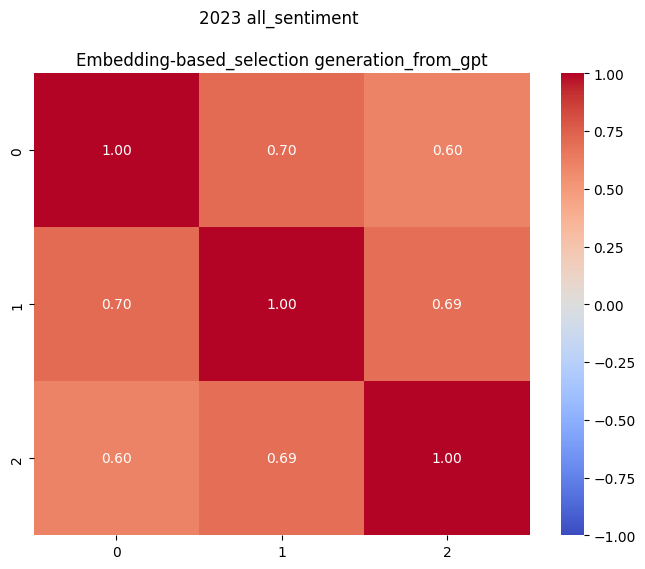

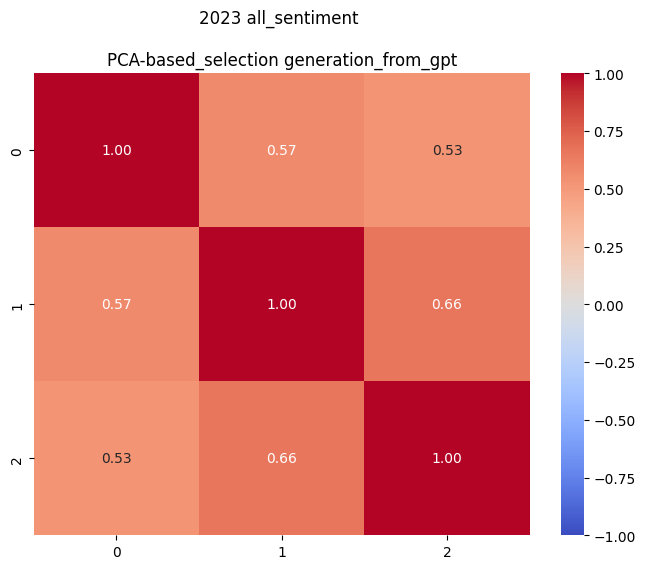

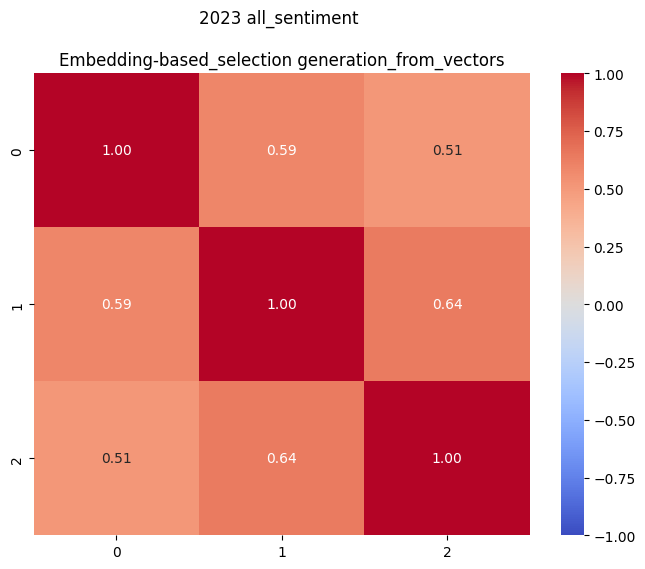

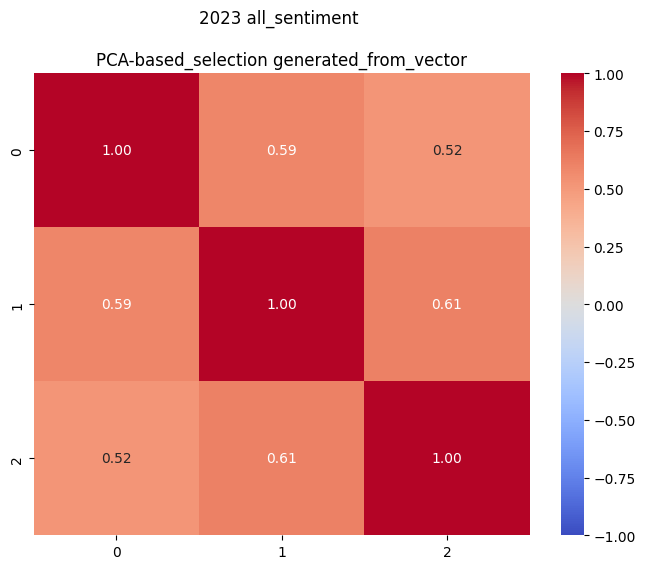

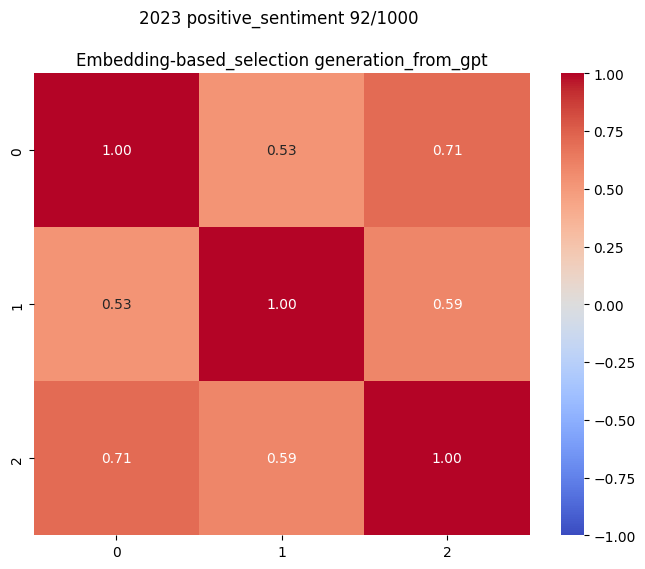

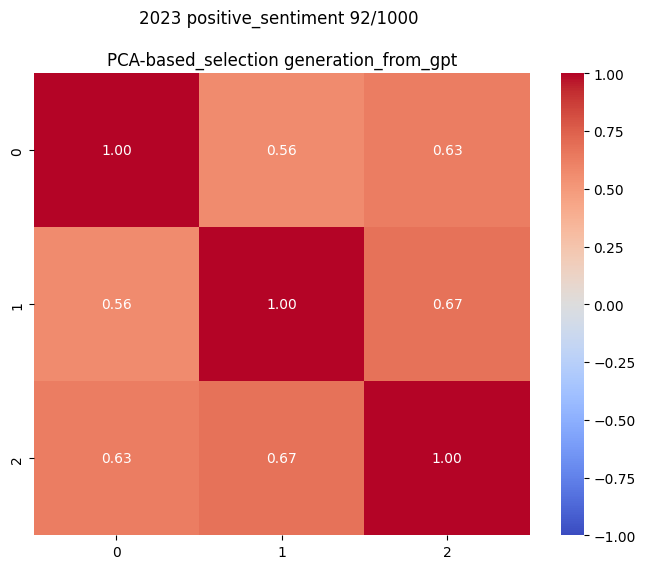

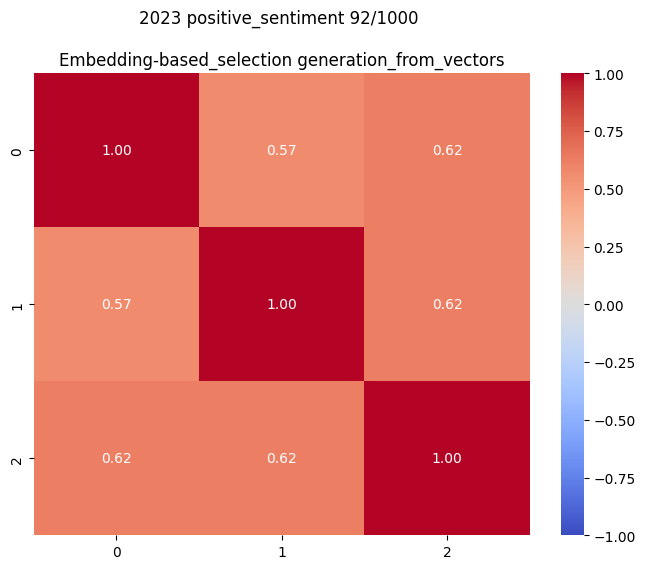

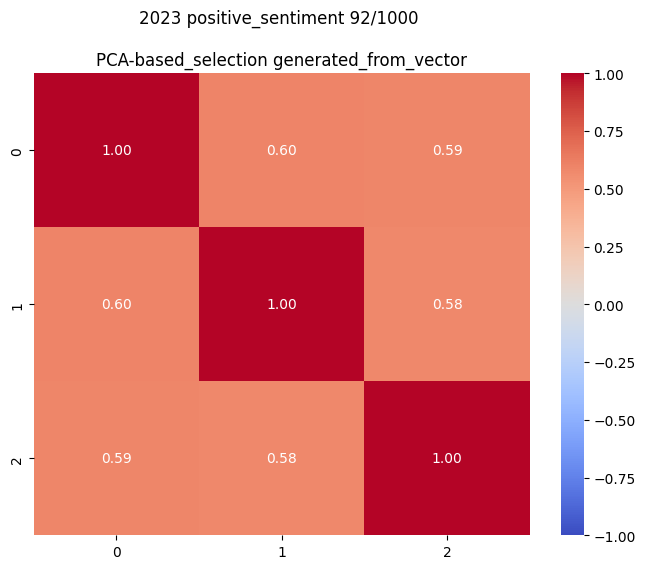

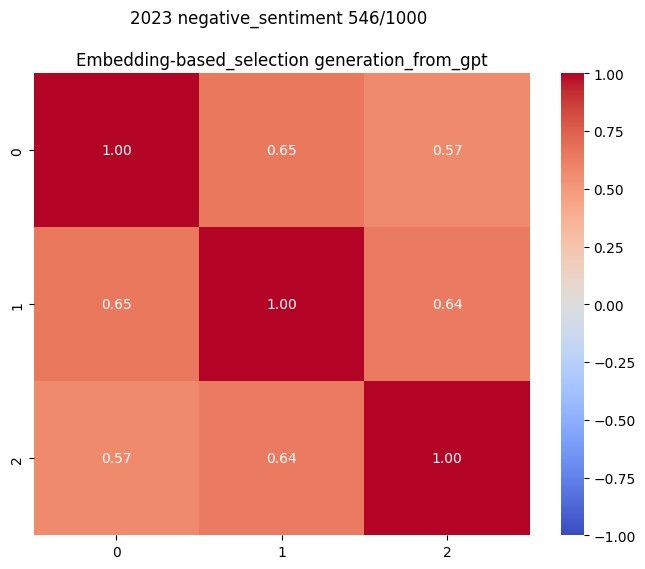

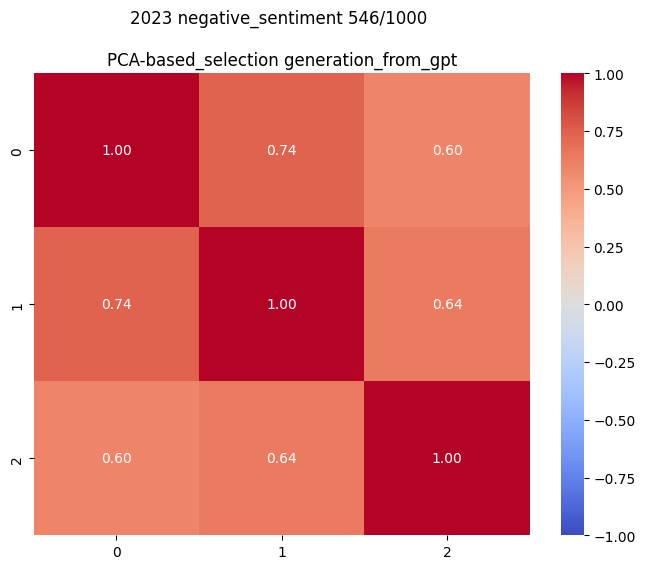

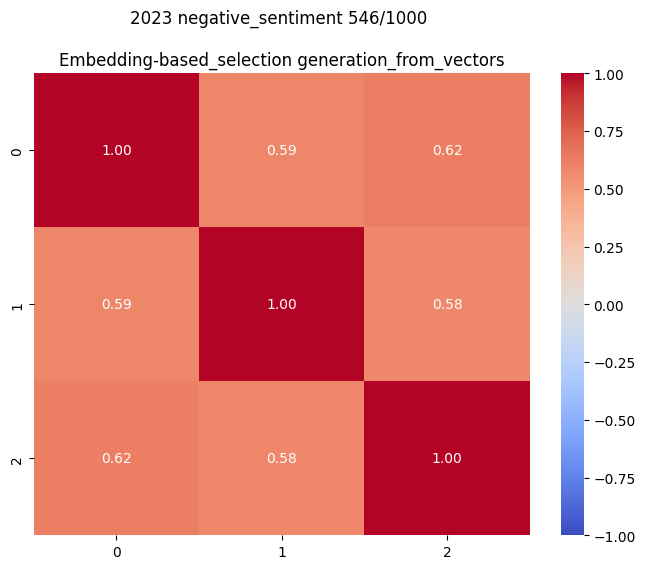

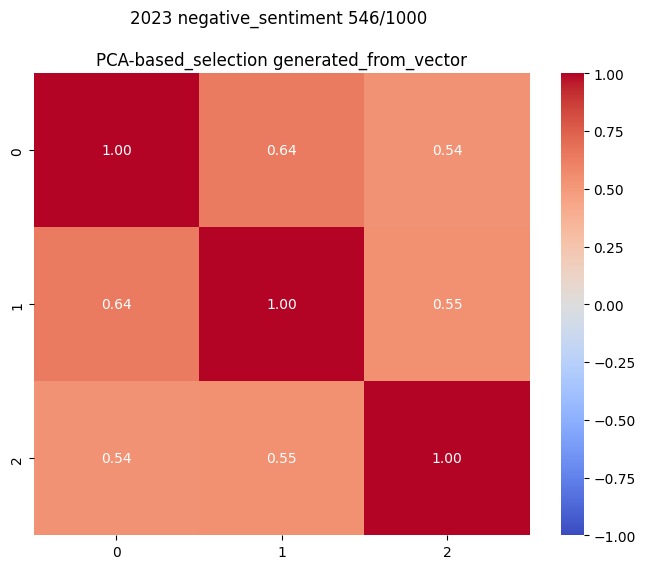

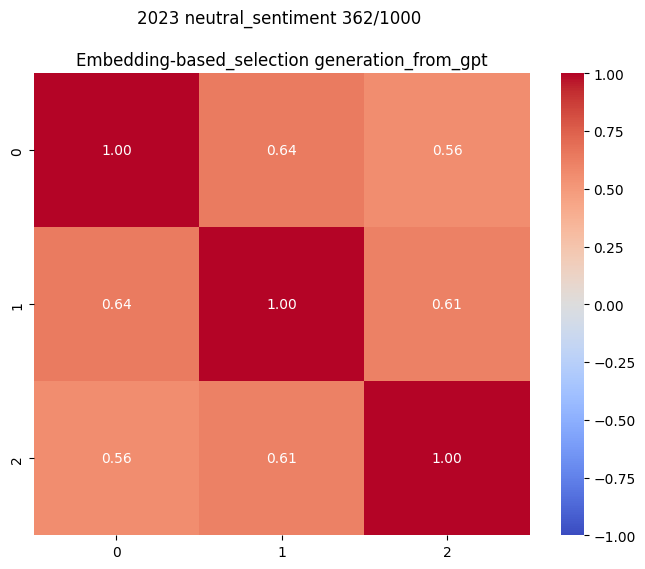

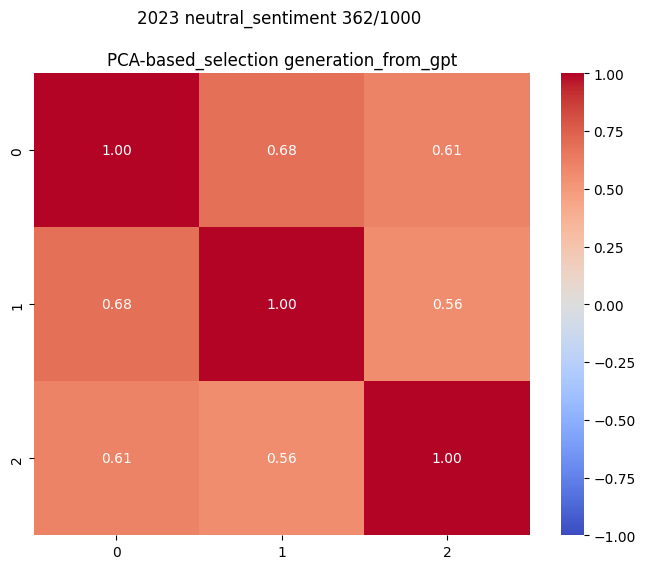

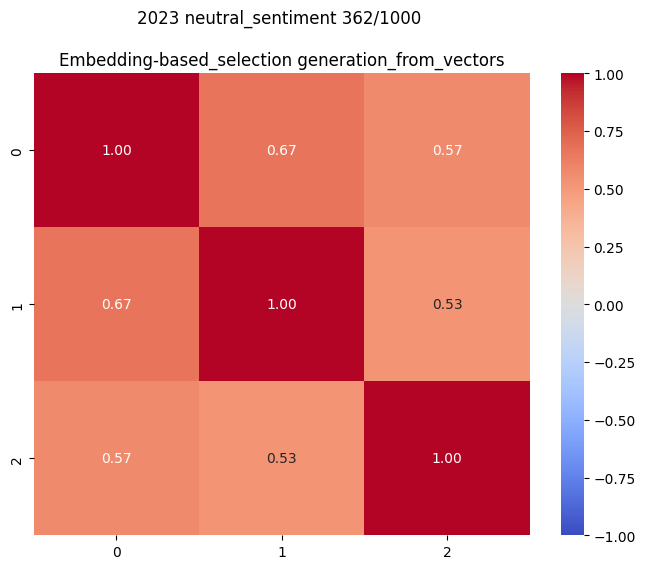

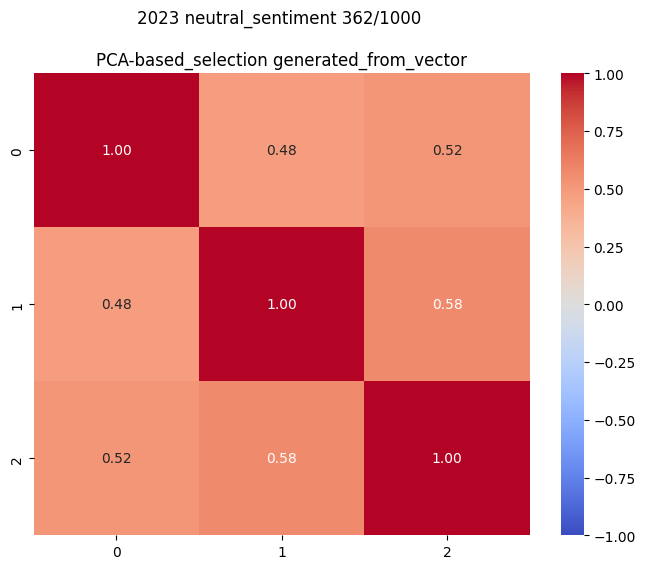

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


for k1, v1 in all_summary_sentence.items():
    for k2, v2 in v1.items():

      embedding_model = TextEmbedding()
      embeddings = embedding_model.embed_texts(v2).cpu()
      similarity_matrix = cosine_similarity(embeddings)

      # ヒートマップの描画
      plt.figure(figsize=(8, 6))
      sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

      # タイトルの設定
      plt.title(f'{k1} {k2}')
      plt.show()
      print()

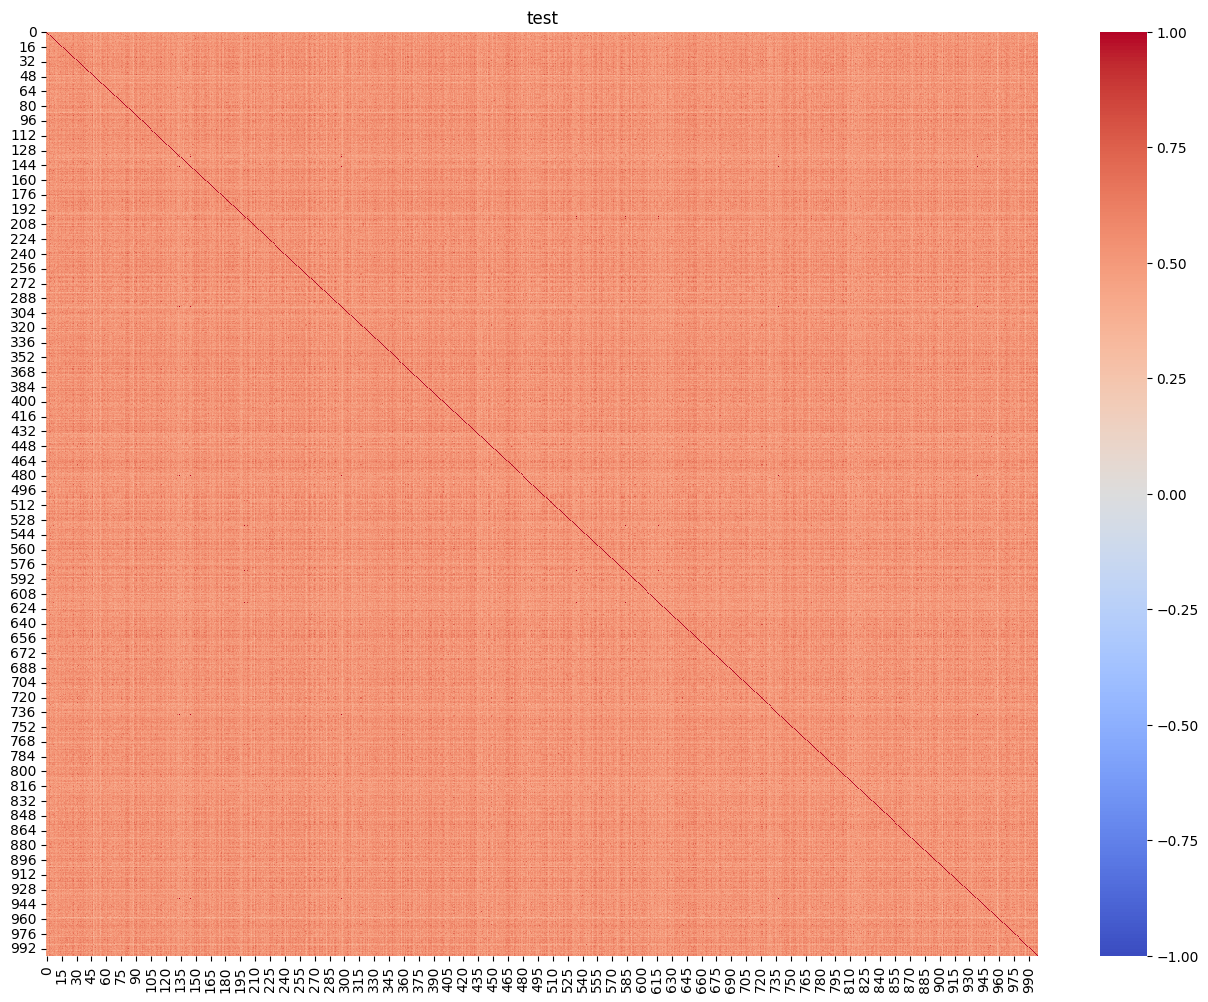

In [12]:
import random
texts = random.sample(text_list, min(len(text_list),1000))


embedding_model = TextEmbedding()
embeddings = embedding_model.embed_texts(texts).cpu()
similarity_matrix = cosine_similarity(embeddings)

plt.figure(figsize=(16, 12))
sns.heatmap(similarity_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

plt.title(f'text_similarity_matrix')
plt.xlabel('texts')
plt.ylabel('texts')
plt.show()